In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import optax

In [2]:
N_DOF_FD = 100
N_COLLOCATION_POINTS = 200
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

In [3]:
# Key setting
key = jr.PRNGKey(42)

In [4]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size="scalar",
    out_size="scalar",
    width_size=10,
    depth=4,
    activation=jax.nn.sigmoid,
    key=init_key,
)

In [5]:
pinn(0.2)

Array(-0.68502796, dtype=float32)

In [6]:
mesh_full = jnp.linspace(0.0, 1.0, N_DOF_FD + 2)
mesh = mesh_full[1:-1]

In [7]:
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1.0, 0.0)

In [8]:
rhs_values = rhs_function(mesh)

In [9]:
dx = mesh[1] - mesh[0]
A = jnp.diag(jnp.ones(N_DOF_FD - 1), -1) + jnp.diag(jnp.ones(N_DOF_FD - 1), 1) - jnp.diag(2.0 * jnp.ones(N_DOF_FD))
A /= dx ** 2

In [10]:
finite_difference_sol = jnp.linalg.solve(A, -rhs_values)

In [11]:
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode="constant", constant_values=0.0)

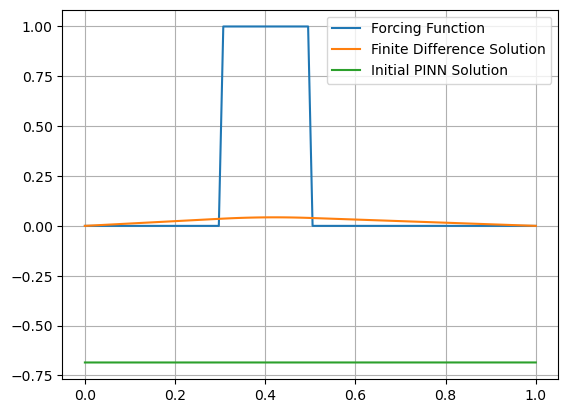

In [12]:
plt.plot(mesh_full, wrap_bc(rhs_values), label="Forcing Function")
plt.plot(mesh_full, wrap_bc(finite_difference_sol), label="Finite Difference Solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Initial PINN Solution")
plt.legend()
plt.grid()
plt.show()

In [13]:
def pde_residuum(model, x):
    return jax.grad(jax.grad(model))(x) + rhs_function(x)

In [14]:
pde_residuum(pinn, 0.8)

Array(-2.5913748e-06, dtype=float32)

In [15]:
key, sampling_key = jr.split(key)
collocation_points = jr.uniform(sampling_key, (N_COLLOCATION_POINTS,), minval=0.0 + 0.001, maxval=1.0 - 0.001)

def loss_fn(model):
    pde_residuum_at_collocation_points = jax.vmap(pde_residuum, in_axes=(None, 0))(model, collocation_points)
    pde_loss = 0.5 * jnp.mean(pde_residuum_at_collocation_points**2)

    left_bc_residuum = model(0.0) - 0.0
    right_bc_residuum = model(1.0) - 0.0
    bc_loss = 0.5 * (left_bc_residuum**2 + right_bc_residuum**2)

    return pde_loss + BC_LOSS_WEIGHT * bc_loss

In [16]:
loss_fn(pinn)

Array(47.00226, dtype=float32)

In [17]:
# Training loop
opt = optax.adam(LEARNING_RATE)
opt_state = opt.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def update_fn(model, state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = opt.update(grads, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

In [18]:
losses = []
for epoch in range(N_EPOCHS):
    pinn, opt_state, loss = update_fn(pinn, opt_state)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

Epoch 0, Loss: 47.00225830078125
Epoch 100, Loss: 0.8480579257011414
Epoch 200, Loss: 0.0799989402294159
Epoch 300, Loss: 0.07999769598245621
Epoch 400, Loss: 0.0799974873661995
Epoch 500, Loss: 0.07999725639820099
Epoch 600, Loss: 0.0799969956278801
Epoch 700, Loss: 0.07999671250581741
Epoch 800, Loss: 0.07999640703201294
Epoch 900, Loss: 0.07999607175588608
Epoch 1000, Loss: 0.07999571412801743
Epoch 1100, Loss: 0.07999533414840698
Epoch 1200, Loss: 0.07999493181705475
Epoch 1300, Loss: 0.07999451458454132
Epoch 1400, Loss: 0.07999405264854431
Epoch 1500, Loss: 0.0799935907125473
Epoch 1600, Loss: 0.07999309152364731
Epoch 1700, Loss: 0.07999256253242493
Epoch 1800, Loss: 0.07999202609062195
Epoch 1900, Loss: 0.07999143749475479
Epoch 2000, Loss: 0.07999083399772644
Epoch 2100, Loss: 0.07999018579721451
Epoch 2200, Loss: 0.07998950779438019
Epoch 2300, Loss: 0.07998878508806229
Epoch 2400, Loss: 0.0799880176782608
Epoch 2500, Loss: 0.07998720556497574
Epoch 2600, Loss: 0.079986333847

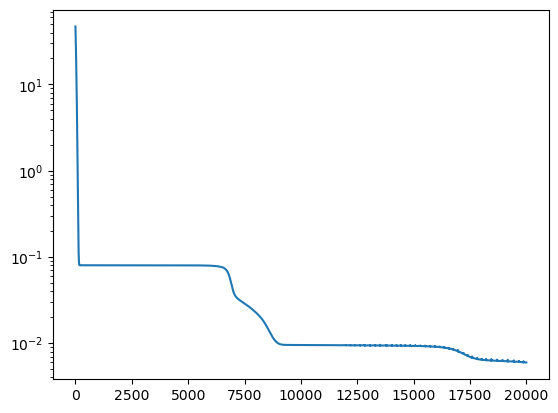

In [19]:
plt.plot(losses)
plt.yscale("log")

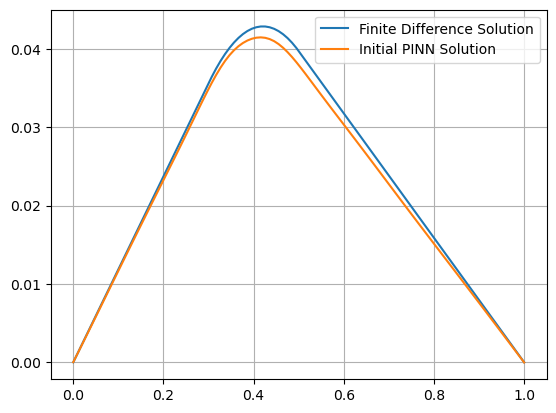

In [20]:
plt.plot(mesh_full, wrap_bc(finite_difference_sol), label="Finite Difference Solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Initial PINN Solution")
plt.legend()
plt.grid()

In [21]:
pinn(0.33), jax.grad(pinn)(0.33)

(Array(0.03790583, dtype=float32), Array(0.08736317, dtype=float32))